In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


In [3]:
# read the data
df=pd.read_csv('/Users/web/Library/CloudStorage/Dropbox/NTU_course/Senior1/ML_HT/code/final_regular/JSH/train_data_add_nearby/500101008.csv', header=None)
df

,0,1,2,3,4,5,6,7
0,500101008,20231002,1,17,1,25.02112,121.53407,16
1,500101008,20231002,2,17,1,25.02112,121.53407,16
2,500101008,20231002,3,17,1,25.02112,121.53407,16
3,500101008,20231002,4,17,1,25.02112,121.53407,16
4,500101008,20231002,5,17,1,25.02112,121.53407,16
...,...,...,...,...,...,...,...,...
60675,500101008,20231123,1435,17,1,25.02112,121.53407,6
60676,500101008,20231123,1436,17,1,25.02112,121.53407,6
60677,500101008,20231123,1437,17,1,25.02112,121.53407,6
60678,500101008,20231123,1438,17,1,25.02112,121.53407,6


In [4]:
# name the columns
df.columns = ["stationID", "date", "minute of day", "tot", "act", "lng", "lat", "bikes"]
df

,stationID,date,minute of day,tot,act,lng,lat,bikes
0,500101008,20231002,1,17,1,25.02112,121.53407,16
1,500101008,20231002,2,17,1,25.02112,121.53407,16
2,500101008,20231002,3,17,1,25.02112,121.53407,16
3,500101008,20231002,4,17,1,25.02112,121.53407,16
4,500101008,20231002,5,17,1,25.02112,121.53407,16
...,...,...,...,...,...,...,...,...
60675,500101008,20231123,1435,17,1,25.02112,121.53407,6
60676,500101008,20231123,1436,17,1,25.02112,121.53407,6
60677,500101008,20231123,1437,17,1,25.02112,121.53407,6
60678,500101008,20231123,1438,17,1,25.02112,121.53407,6


In [5]:
# make date_time format correct
df[['hr','minutes']] = df['minute of day'].apply(lambda x: divmod(x, 60)).apply(pd.Series)

# Combine 'date' and 'time' columns into a single datetime column
df['datetime'] = pd.to_datetime( df['date'].astype(str) + ' ' + df['hr'].astype(str) + ":" + df['minutes'].astype(str),  format='%Y%m%d %H:%M' )
df.set_index('datetime',inplace=True)
tot = df['tot'][0]

In [6]:
bike_number = df["bikes"]
bike_number.head(400)

datetime
2023-10-02 00:01:00    16
2023-10-02 00:02:00    16
2023-10-02 00:03:00    16
2023-10-02 00:04:00    16
2023-10-02 00:05:00    16
                       ..
2023-10-02 06:45:00    15
2023-10-02 06:46:00    15
2023-10-02 06:47:00    14
2023-10-02 06:48:00    14
2023-10-02 06:49:00    14
Name: bikes, Length: 400, dtype: int64

Text(0, 0.5, 'Amplitude')

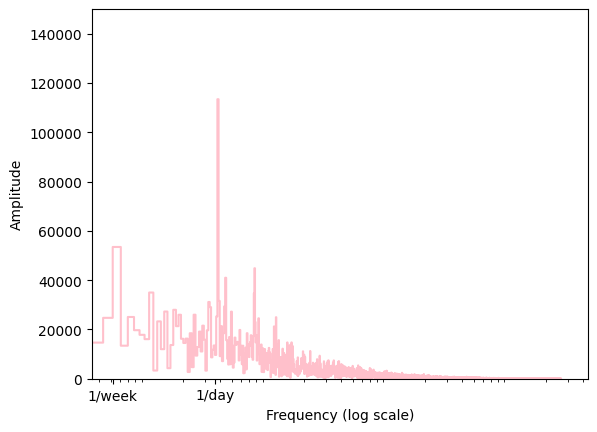

In [23]:
# do fft to see periodicity
fft = tf.signal.rfft(bike_number)
f_per_dataset = np.arange(0, len(fft))

n_samples_min = len(bike_number)
min_per_year = 60*24*365.2524
min_per_dataset = n_samples_min/(min_per_year)

f_per_min = f_per_dataset/min_per_dataset
plt.step(f_per_min, np.abs(fft), color='pink')
plt.xscale('log')
plt.ylim(0, 150000)
plt.xlim([35, max(plt.xlim())])
plt.xticks([52.1789, 365.2524], labels=['1/week', '1/day'])
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude')

In [57]:
# normalize the data, 
from sklearn.preprocessing import MinMaxScaler
bike_number_2d = bike_number.values.reshape(-1, 1)
normalized_bike_number = MinMaxScaler().fit_transform( bike_number_2d )

pd.DataFrame(normalized_bike_number)
df['normalized_bikes'] = normalized_bike_number
normalized_bike_number = pd.DataFrame(df['normalized_bikes'])

normalized_bike_number.head()

,normalized_bikes
datetime,
2023-10-02 00:01:00,0.941176
2023-10-02 00:02:00,0.941176
2023-10-02 00:03:00,0.941176
2023-10-02 00:04:00,0.941176
2023-10-02 00:05:00,0.941176


In [58]:
# split the data, (70%, 20%, 10%) split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(normalized_bike_number.columns)}

n = len(normalized_bike_number)
train_df = normalized_bike_number[0:int(n*0.7)]
val_df = normalized_bike_number[int(n*0.7):int(n*0.9)]
test_df = normalized_bike_number[int(n*0.9):]

num_features = normalized_bike_number.shape[1]

In [59]:
# Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [60]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [61]:
# create tf dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [62]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [63]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['normalized_bikes'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['normalized_bikes']

In [64]:
# function for fitting the model
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [67]:
def plot(self, model=None, plot_col='normalized_bikes', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='none', label='Labels', c='#2ca02c', s=32)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='none', label='Predictions',
                  c='#ff7f0e', s=32)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## single time step lstm

In [43]:
# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

In [44]:
# print('Input shape:', wide_window.example[0].shape)
# print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [45]:
# history = compile_and_fit(lstm_model, wide_window)



Epoch 1/10
1327/1327 [==============================] - 5s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0420 - val_loss: 7.9823e-04 - val_mean_absolute_error: 0.0126
Epoch 2/10
1327/1327 [==============================] - 4s 3ms/step - loss: 8.1002e-04 - mean_absolute_error: 0.0119 - val_loss: 5.5733e-04 - val_mean_absolute_error: 0.0089
Epoch 3/10
1327/1327 [==============================] - 4s 3ms/step - loss: 7.1732e-04 - mean_absolute_error: 0.0106 - val_loss: 5.6179e-04 - val_mean_absolute_error: 0.0105
Epoch 4/10
1327/1327 [==============================] - 4s 3ms/step - loss: 7.0909e-04 - mean_absolute_error: 0.0107 - val_loss: 5.4419e-04 - val_mean_absolute_error: 0.0090
Epoch 5/10
1327/1327 [==============================] - 4s 3ms/step - loss: 7.0303e-04 - mean_absolute_error: 0.0106 - val_loss: 5.6603e-04 - val_mean_absolute_error: 0.0121
Epoch 6/10
1327/1327 [==============================] - 4s 3ms/step - loss: 6.9831e-04 - mean_absolute_error: 0.0103 - val_loss: 5.456

In [46]:
# lstm_model.evaluate(wide_window.val)
# lstm_model.evaluate(wide_window.test, verbose=0)

379/379 [==============================] - 0s 1ms/step - loss: 5.4567e-04 - mean_absolute_error: 0.0107


[0.0007102218805812299, 0.012107416987419128]

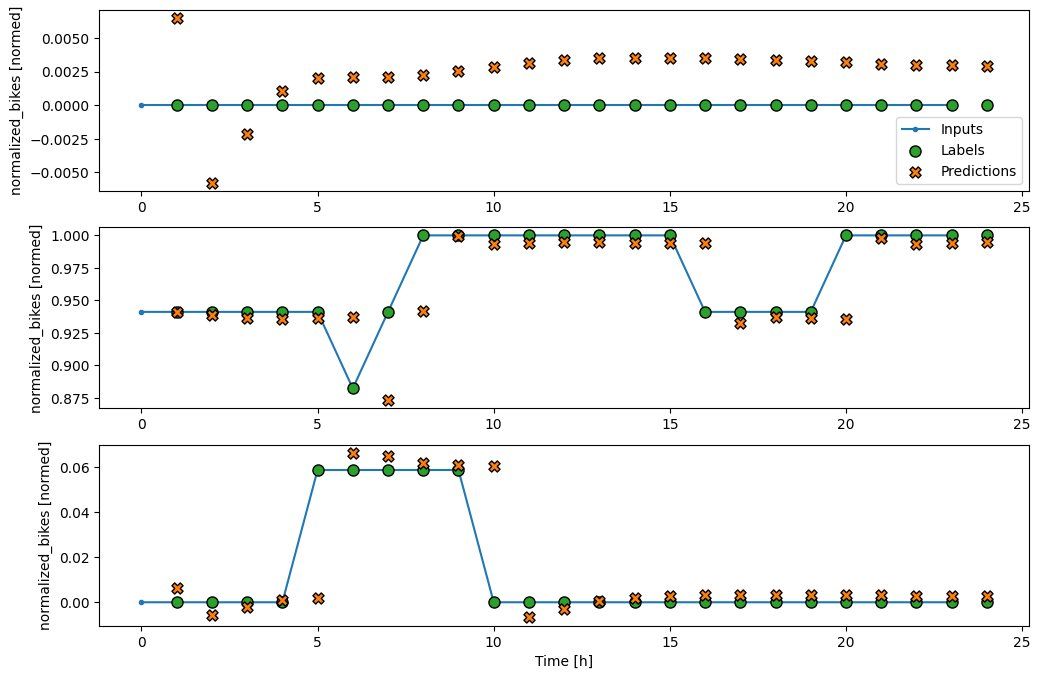

In [47]:
# wide_window.plot(lstm_model)

## multi time step lstm

Total window size: 2878
Input indices: [   0    1    2 ... 1436 1437 1438]
Label indices: [1439 1440 1441 ... 2875 2876 2877]
Label column name(s): None

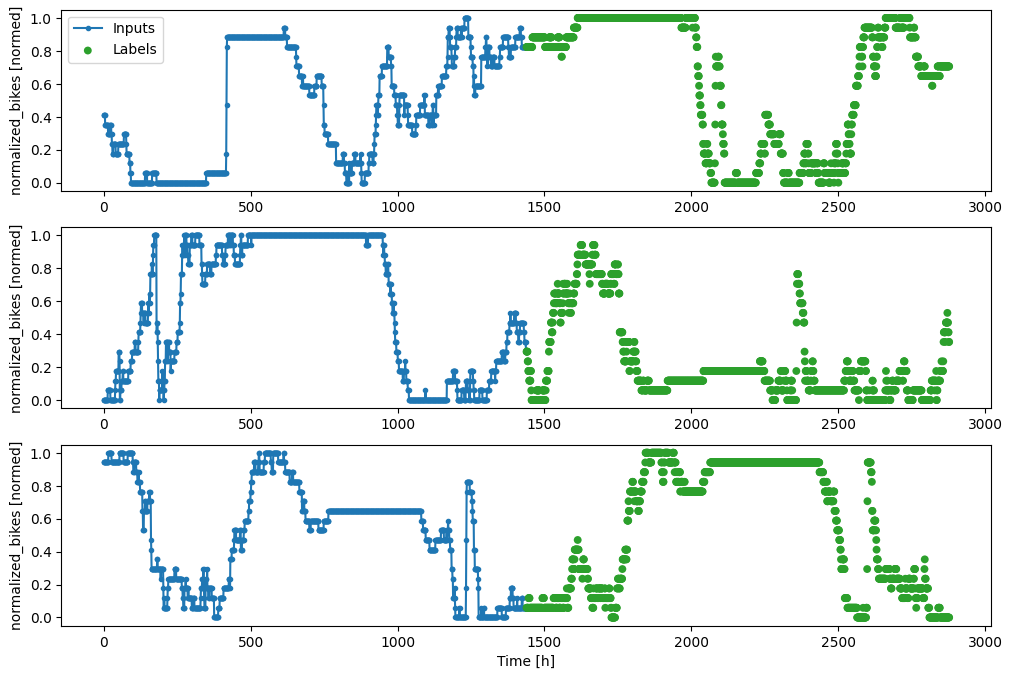

In [68]:
OUT_STEPS = 1439
multi_window = WindowGenerator(input_width=1439,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

290/290 [==============================] - 9s 31ms/step - loss: 0.1416 - mean_absolute_error: 0.3385


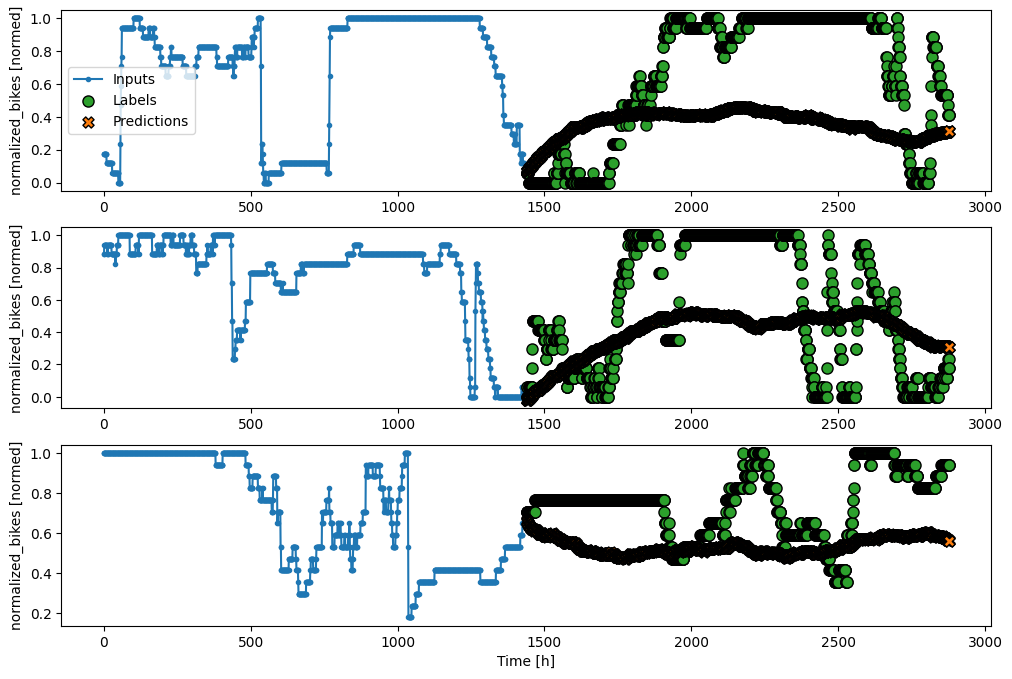

In [56]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()



290/290 [==============================] - 9s 31ms/step - loss: 0.1416 - mean_absolute_error: 0.3385


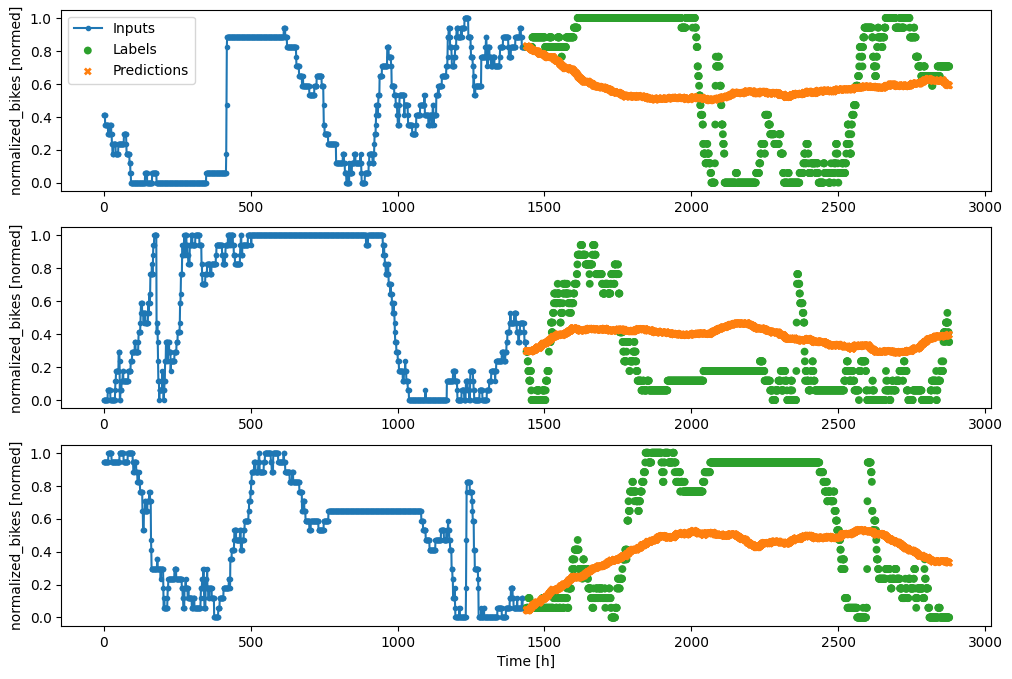

In [69]:
multi_lstm_model.evaluate(multi_window.val)
multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)